Adding more indicators to model

## Imports

In [1]:
import os
supp_path = 'C:/Users/joepo/Desktop/Back Testing/Supplemental'
import sys
sys.path.insert(1, supp_path)
import rando 
import strats
import myIndicators as mind
import model_analysis as ma

import backtrader as bt
import datetime
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
%matplotlib inline

## Variables

In [2]:
allTickers = ['ABT', 'ATVI', 'CSCO', 'CVS', 'LOW', 'NKE', 'SBUX', 'T'
              , 'BAC', 'DAL', 'GE', 'SIRI', 'WFC'
              , 'GOOG', 'GME', 'LB', 'LUV', 'AAL','HD', 'UAA'
              , 'WMT', 'JPM', 'BCS', 'YUM', 'BA', 'AAPL', 'C'
              , 'DIS', 'GILD', 'H', 'K', 'KO', 'M'
              , 'MSFT', 'NVDA', 'NFLX', 'PENN', 'QCOM', 'RCL'
              , 'USO', 'V', 'VZ'
              , 'WFC', 'X', 'XOM']
allTickersOOS = ['ABT', 'ATVI', 'CSCO', 'CVS', 'LOW', 'NKE', 'SBUX', 'T'
              , 'BAC', 'DAL', 'GE', 'SIRI', 'WFC'
              , 'GOOG', 'GME', 'LB', 'LUV', 'AAL','HD', 'UAA'
              , 'WMT', 'JPM', 'BCS', 'YUM', 'BA', 'AAPL', 'C'
              , 'DIS', 'GILD', 'H', 'K', 'KO', 'M'
              , 'MSFT', 'NVDA', 'NFLX', 'PENN', 'QCOM', 'RCL'
              , 'USO', 'V', 'VZ'
              , 'WFC', 'X', 'XOM']
startDate = '2018-1-1'
endDate = '2020-5-15'
datedict = {'d':'%Y-%m-%d'}
iterator = 'd'
outPath = 'C:/Users/joepo/Desktop/Back Testing/Data/Testing'

#for model building
start_train = '2018-1-1'
end_train = '2019-12-31'

start_test = '2020-1-1'
end_test = '2020-5-15'

In [3]:
startingcash = 200000
sizingperc = 0.05
fast_sma = 20
slow_sma = 100
boll_std = 1
range_dist_min = 1.7
range_dist_max = 2.3
exit_dist = 3.15
reset_dist = 1.15
rsi_thresh = 20
rsi_close = 10
rsi_period = 14
profit = 0.075

## Download Data

In [4]:
#get dates for data
today = date.today()
#endDate = datetime.datetime.strftime(today, datedict[iterator])
start = today - datetime.timedelta(days = 350)

#iterate through tickers and download data
print('Downloading data ... ')
for t in allTickers:
    print(t)
    data = pdr.get_data_yahoo(t.strip().upper(), start=startDate, end=endDate)
    data.to_csv(os.path.join(outPath, t+'.csv'))

ABT
[*********************100%***********************]  1 of 1 completed
ATVI
[*********************100%***********************]  1 of 1 completed
CSCO
[*********************100%***********************]  1 of 1 completed
CVS
[*********************100%***********************]  1 of 1 completed
LOW
[*********************100%***********************]  1 of 1 completed
NKE
[*********************100%***********************]  1 of 1 completed
SBUX
[*********************100%***********************]  1 of 1 completed
T
[*********************100%***********************]  1 of 1 completed
BAC
[*********************100%***********************]  1 of 1 completed
DAL
[*********************100%***********************]  1 of 1 completed
GE
[*********************100%***********************]  1 of 1 completed
SIRI
[*********************100%***********************]  1 of 1 completed
WFC
[*********************100%***********************]  1 of 1 completed
GOOG
[*********************100%*******************

# Get Data (Specific Timeframes)

In [5]:
start_train_dt = datetime.datetime.strptime('2018-1-1', datedict[iterator])
end_train_dt = datetime.datetime.strptime('2019-12-31', datedict[iterator])

start_test_dt = datetime.datetime.strptime('2019-8-10', datedict[iterator])
end_test_dt = datetime.datetime.strptime('2020-5-15', datedict[iterator])

## Strategy

In [16]:
class live_model_1(bt.Strategy):
    '''
    SMA mean reverting
    '''
    params = dict(
        sizingPerc = 0.01
        ,fastSMA = 20
        ,slowSMA = 100
        ,bollStd = 1
        ,rangeLow = 1.75
        ,rangeHigh = 2.25
        ,stopRange = 2.5
        ,resetRange = 1.5
        ,rsiBound = 20
        ,rsiClose = 5
        ,rsiPeriod = 14
        ,profitTake = 0.1
        ,printLog = True
        ,adxPeriod = 14
        ,cmfPeriod = 14
        ,obvPeriod = 14
        )

    def __init__(self):
        self.startCash = None
        self.order = {}
        self.stoploss = {}
        self.fastSlow = {}
        self.smaCrosses = {}
        self.distInRange = {}
        self.revertEarly = {}
        self.rsiCross = {}
        self.ls = {}
        self.highStop = {}
        self.lowStop = {}
        self.tradedata = {}
        self.reldata = {}
        self.price = {}
        self.inds = {}
        for i, d in enumerate(self.datas):
            self.order[d] = None
            self.stoploss[d] = None
            self.fastSlow[d] = None
            self.smaCrosses[d] = 0
            self.distInRange[d] = False
            self.revertEarly[d] = False
            self.rsiCross[d] = None
            self.ls[d] = 0
            self.highStop[d] = 0
            self.lowStop[d] = 0
            self.reldata[d] = []
            self.price[d] = 0
            self.inds[d] = {}
            self.inds[d]['sma fast'] = bt.ind.SMA(d.close, period = self.p.fastSMA).lines.sma
            self.inds[d]['sma slow'] = bt.ind.SMA(d.close, period = self.p.slowSMA).lines.sma
            self.inds[d]['bands'] = bt.ind.BBands(d.close, period = self.p.fastSMA, devfactor = self.p.bollStd, plot=False)
            self.inds[d]['band diff'] = self.inds[d]['bands'].lines.top - self.inds[d]['bands'].lines.mid
            self.inds[d]['rsi'] = bt.ind.RSI_SMA(d.close, period = self.p.rsiPeriod).lines.rsi
            self.inds[d]['rsi buy'] = bt.ind.CrossDown(self.inds[d]['rsi'], 50 - self.p.rsiBound, plot=False)
            self.inds[d]['rsi sell'] = bt.ind.CrossUp(self.inds[d]['rsi'], 50 + self.p.rsiBound, plot=False)
            self.inds[d]['rsi close long'] = bt.ind.CrossUp(self.inds[d]['rsi'], 50 + self.p.rsiClose, plot=False)
            self.inds[d]['rsi close short'] = bt.ind.CrossDown(self.inds[d]['rsi'], 50 - self.p.rsiClose, plot=False)
            self.inds[d]['adx'] = bt.ind.ADX(d, period=self.p.adxPeriod).lines.adx
            self.inds[d]['cmf'] = mind.ChaikinMoneyFlow(d, period=self.p.cmfPeriod, plot=False).lines.mfi
            self.inds[d]['obv'] = mind.OBV(d, length=self.p.obvPeriod, plot=False).lines.obv
            

    def start(self):
        self.startCash = self.broker.getvalue()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            d = order.data
            if order.isbuy():
                bs = "Bought"
                self.ls[d] = 1
            else:
                bs = "Sold"
                self.ls[d] = -1
            desc = "{} {} shares of {} for ${:.2f}".format(bs, order.executed.size, d._name, order.executed.price)
            self.log(desc)
            self.price[d] = order.executed.price
            if len(self.reldata[d]) == 17:
                self.reldata[d].append('Stop')
            self.reldata[d].append(desc)
        elif order.status in [order.Canceled]:
            self.log('Order Canceled for {}'.format(order.data._name))
        elif order.status in [order.Margin, order.Rejected]:
            self.log('Order rejected or margin issue')

    def notify_trade(self, trade):
        d = trade.data
        if not trade.isclosed:
            return
        self.reldata[d].append(trade.pnlcomm)
        self.tradedata[self.reldata[d][16]] = self.reldata[d]
        self.cancel(self.stoploss[d])
        self.stoploss[d] = None
        self.resetBools(d)

    def resetBools(self, t):
        self.fastSlow[t] = None
        self.smaCrosses[t] = 0
        self.distInRange[t] = False
        self.revertEarly[t] = False
        self.rsiCross[t] = None
        self.ls[t] = 0
        self.reldata[t] = []
        self.price[t] = 0

    def log(self, txt, dp=False):
        if self.p.printLog or dp:
            date = self.datas[0].datetime.date(0)
            print("{}: {}".format(date, txt))

    def sizingCalc(self, capital, price):
        available = float(capital) * self.p.sizingPerc
        shares = round(available/price)
        return shares

    def awayThreshold(self, thresh, fast, close, ab):
        if ab == "Above":
            new = float(fast) * (1 + float(thresh))
            if float(close) > new:
                return True
            else:
                return False
        elif ab == "Below":
            new = float(fast) * (1 - float(thresh))
            if float(close) < new:
                return True
            else:
                return False
        else:
            self.log("awayThreshold:  We have a problem: {}".format(ab))

    def resetAway(self, reset, fast, close, ab):
        if ab == "Above":
            new = float(fast) * (1 + float(reset))
            if float(close) > new:
                return True
            else:
                return False
        elif ab == "Below":
            new = float(fast) * (1 - float(reset))
            if float(close) < new:
                return True
            else:
                return False

    def next(self):
        for i, d in enumerate(self.datas):
            fast = self.inds[d]['sma fast'][0]
            slow = self.inds[d]['sma slow'][0]
            bollWidth = self.inds[d]['band diff'][0]
            rsi = self.inds[d]['rsi'][0]
            close = d.close[0]
            ticker = d._name
            adx = self.inds[d]['adx'][0]
            cmf = self.inds[d]['cmf'][0]
            obv = self.inds[d]['obv'][0]
            obvYest = self.inds[d]['obv'][-1]
            obvChange = (obv - obvYest)/obvYest
            obvChangeAbs = abs(obvChange)
            if self.getposition(d).size == 0: ##not in market
                if fast > slow: ##fast above slow ma
                    self.fastSlow[d] = "Above"
                    if self.distInRange[d]:
                        if close < fast + (bollWidth * self.p.resetRange):
                            ##fell out of range
                            self.distInRange[d] = False
                        else:
                            ##still in range
                            if self.inds[d]['rsi sell'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.sell(data=d, size=numShares)
                                self.log("Sell {} shares of {}".format(numShares, ticker))
                                #self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append(rsi - (50 + self.p.rsiBound))
                                self.reldata[d].extend([adx, cmf, obv, obvChange, obvChangeAbs])
                    else:
                        lowRange = bollWidth * self.p.rangeLow
                        highRange = bollWidth * self.p.rangeHigh
                        if close > (fast + lowRange) and close < (fast + highRange):
                            self.distInRange[d] = True
                            if self.inds[d]['rsi sell'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.sell(data=d, size=numShares)
                                self.log("Sell {} shares of {}".format(numShares, ticker))
                                #self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append(rsi - (50 + self.p.rsiBound))
                                self.reldata[d].extend([adx, cmf, obv, obvChange, obvChangeAbs])

                elif fast < slow: ##fast below slow sma
                    self.fastSlow[d] = "Below"
                    if self.distInRange[d]:
                        if close > fast - (bollWidth * self.p.resetRange):
                            ##fell out of range
                            self.distInRange[d] = False
                        else:
                            ##still in range
                            if self.inds[d]['rsi buy'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.buy(data=d, size = numShares)
                                self.log("Buy {} shares of {}".format(numShares, ticker))
                                #self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append((50 - self.p.rsiBound) - rsi)
                                self.reldata[d].extend([adx, cmf, obv, obvChange, obvChangeAbs])
                    else:
                        lowRange = bollWidth * self.p.rangeLow
                        highRange = bollWidth * self.p.rangeHigh
                        if close > (fast - highRange) and close < (fast - lowRange):
                            self.distInRange[d] = True
                            if self.inds[d]['rsi buy'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.buy(data=d, size = numShares)
                                self.log("Buy {} shares of {}".format(numShares, ticker))
                                #self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append((50 - self.p.rsiBound) - rsi)
                                self.reldata[d].extend([adx, cmf, obv, obvChange, obvChangeAbs])

            else:
                if self.ls[d] < 0: ##sold
                    if self.stoploss[d] is None:
                        self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price=self.highStop[d]
                                                      )
                        self.log("Buy stop created at ${:.2f} for {}".format(
                            self.highStop[d], ticker))
                    ##check for rsi cross
                    if close < self.price[d] * (1-self.p.profitTake):
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("Take {}% profit and close {}".format(self.p.profitTake*100.0, ticker))
                        self.reldata[d].append('Profit')
                    elif self.inds[d]['rsi close short'].lines.cross[0] > 0:
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("RSI broke below for {}, close position".format(ticker))
                        self.reldata[d].append('RSI')
                    ##check for number of sma crosses #starts above
                    elif self.smaCrosses[d] == 0:
                        ##check for sma cross below
                        if fast < slow:
                            self.smaCrosses[d] = 1
                    elif self.smaCrosses[d] == 1:
                        if fast > slow:
                            ##sma crossed back above, exit short position
                            self.order[d] = self.close(data=d)
                            self.cancel(self.stoploss[d])
                            self.log("Upward momentum with SMA crossing up for {}, close position".format(ticker))
                            self.reldata[d].append('SMA Cross')
                else:  ##bought
                    if self.stoploss[d] is None:
                        self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price=self.lowStop[d]
                                                      )
                        self.log("Sell stop created at ${:.2f} for {}".format(
                            self.lowStop[d], ticker))
                    if close > self.price[d] * (1+self.p.profitTake):
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("Take {}% profit and close {}".format(self.p.profitTake*100.0, ticker))
                        self.reldata[d].append('Profit')
                    ##check for rsi cross
                    elif self.inds[d]['rsi close long'].lines.cross[0] > 0:
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("RSI broke above for {}, close position".format(ticker))
                        self.reldata[d].append('RSI')
                    elif self.smaCrosses[d] == 0:
                        ##check for sma cross above
                        if fast > slow:
                            self.smaCrosses[d] = 1
                    elif self.smaCrosses[d] == 1:
                        if fast < slow:
                            ##sma crossed back below, exit long position
                            self.order[d] = self.close(data=d)
                            self.cancel(self.stoploss[d])
                            self.log("Downard momentum with SMA crossing down for {}, close position".format(ticker))
                            self.reldata[d].append('SMA Cross')
                        
    def stop(self):
        pnl = self.broker.getvalue() - self.startCash
        print("\n\n ------- Final Analysis ------- ")
        print("Ending Value: ${:.2f}\nP&L:  ${:.2f}\n".format(self.broker.getvalue(), pnl))

In [13]:
class custom_analyzer(bt.Analyzer):
    def get_analysis(self):
        return self.strategy.tradedata

In [14]:
class custom_analyzer2(bt.Analyzer):
    def get_analysis(self):
        return self.strategy.broker.getvalue() - self.strategy.startCash

## Run Strategy

In [17]:
allData = []
pnls = []
for t in allTickers:
    print(t)
    cerebro = bt.Cerebro()
    data = bt.feeds.GenericCSVData(dataname = os.path.join(outPath, t + '.csv')
                                   ,fromdate = start_train_dt
                                   ,todate = end_train_dt
                                   ,nullvalue = 0.0
                                   ,dtformat = datedict[iterator]
                                   ,datetime = 0
                                   ,high = 2
                                   ,low = 3
                                   ,open = 1
                                   ,close = 4
                                   ,volume = 6
                                   ,openinterest = -1 #no open interest column
                                   )
    cerebro.adddata(data, name=t)
    
    cerebro.broker.set_cash(startingcash)
    print("Running with ${} as starting cash".format(startingcash))
    print("Trading {:.2f}% of portfolio value".format(sizingperc * 100.0))
    cerebro.addstrategy(live_model_1
                    ,sizingPerc = sizingperc
                    ,fastSMA = fast_sma
                    ,slowSMA = slow_sma
                    ,bollStd = boll_std
                    ,rangeLow = range_dist_min
                    ,rangeHigh = range_dist_max
                    ,stopRange = exit_dist
                    ,resetRange = reset_dist
                    ,rsiBound = rsi_thresh
                    ,rsiClose = rsi_close
                    ,rsiPeriod = rsi_period
                    ,profitTake = profit
                    ,printLog = False
                    )
    
    #add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='annRets')
    cerebro.addanalyzer(custom_analyzer, _name='tradeDict')
    cerebro.addanalyzer(custom_analyzer2, _name='pnl')
    
    #run backtest
    test = cerebro.run()
    analysis = test[0]
    
    #get analyzers
    sharpe = analysis.analyzers.sharpe.get_analysis()
    sqn = analysis.analyzers.sqn.get_analysis()
    rets = analysis.analyzers.annRets.get_analysis()
    trade = analysis.analyzers.trades.get_analysis()
    trades = analysis.analyzers.tradeDict.get_analysis()
    pl = analysis.analyzers.pnl.get_analysis()
    
    #print analysis
    print(ma.main_analysis(sharpe, sqn, rets))
    
    allData.append(trades)
    pnls.append(pl)

ABT
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $198932.31
P&L:  $-1067.69

 ------ Quick Glance ------ 
Sharpe Ratio:  -9.57
SQN:  -8.029670793207492
4 total trades
Normalized Return:  -0.27%
Total Return:  -0.01
Average Return:  -0.00
 -------------------------- 

ATVI
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200118.71
P&L:  $118.71

 ------ Quick Glance ------ 
Sharpe Ratio:  -3.74
SQN:  0.10792477911871559
5 total trades
Normalized Return:  0.03%
Total Return:  0.00
Average Return:  0.00
 -------------------------- 

CSCO
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200778.56
P&L:  $778.56

 ------ Quick Glance ------ 
Sharpe Ratio:  -8.36
SQN:  1.0858297744811596
5 total trades
Normalized Return:  0.20%
Total Return:  0.00
Average Return:  0.00
 -------



 ------- Final Analysis ------- 
Ending Value: $202322.07
P&L:  $2322.07

 ------ Quick Glance ------ 
Sharpe Ratio:  -2.40
SQN:  1.6703724778529743
5 total trades
Normalized Return:  0.58%
Total Return:  0.01
Average Return:  0.00
 -------------------------- 

AAPL
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $199349.83
P&L:  $-650.17

 ------ Quick Glance ------ 
Sharpe Ratio:  -5.02
SQN:  -0.291007901385049
10 total trades
Normalized Return:  -0.16%
Total Return:  -0.00
Average Return:  -0.00
 -------------------------- 

C
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $199678.38
P&L:  $-321.62

 ------ Quick Glance ------ 
Sharpe Ratio:  -18.19
SQN:  -0.21743471843347495
5 total trades
Normalized Return:  -0.08%
Total Return:  -0.00
Average Return:  -0.00
 -------------------------- 

DIS
Running with $200000 as starting cash
Trading

In [18]:
sum(pnls)

16718.102987171675

In [19]:
dfs = []
cols = ['Ticker', 'Fast SMA', 'Slow SMA', 'SMA Diff', 'Bollinger Width', 'RSI'
       , 'Fast Norm', 'Slow Norm', 'Diff Norm', 'Boll Norm', 'RSI Extra'
       , 'ADX', 'CMF', 'OBV', 'OBV Change', 'OBV Change Abs.'
       , 'Entry Desc', 'Reason', 'Exit Desc', 'PnL']
for d in allData:
    df = pd.DataFrame.from_dict(d, orient='index', columns=cols).reset_index()
    dfs.append(df)
    
tradeData = pd.concat(dfs).reset_index(drop=True)
tradeData.rename({'index':'Description'}, axis=1, inplace=True)
tradeData['WL'] = tradeData['PnL'].apply(lambda x: 'W' if x > 0 else 'L')
tradeData['LS'] = tradeData['Description'].apply(lambda x: 'Long' if x.split(' ')[0] == 'Bought' else 'Short')
tradeData

Description Ticker   Fast SMA   Slow SMA  \
0     Sold -149 shares of ABT for $66.94    ABT  65.023000  62.227400   
1     Sold -140 shares of ABT for $71.74    ABT  67.533500  63.704200   
2     Sold -138 shares of ABT for $72.00    ABT  69.022499  66.443500   
3     Sold -133 shares of ABT for $75.04    ABT  71.758500  70.493000   
4    Sold -134 shares of ATVI for $74.79   ATVI  71.709000  70.151800   
..                                   ...    ...        ...        ...   
276   Sold -118 shares of XOM for $84.86    XOM  81.471500  81.013500   
277  Bought 132 shares of XOM for $76.24    XOM  79.325500  81.471000   
278  Bought 135 shares of XOM for $74.14    XOM  76.992500  77.314900   
279  Bought 143 shares of XOM for $69.27    XOM  73.531499  76.801199   
280  Bought 148 shares of XOM for $67.00    XOM  71.461000  73.099700   

     SMA Diff  Bollinger Width        RSI  Fast Norm  Slow Norm  Diff Norm  \
0    2.795600         1.062384  72.677617   0.968613   0.926969   0.041645   
1    3.829300         1.301197  75.321639   0.945318   0.891716   0.053602   
2    2.578999         1.478280  71.626983   0.952034   0.916462   0.035572   
3    1.265500         1.550626  71.298575   0.956015   0.939155   0.016860   
4    1.557200         1.080879  72.801652   0.958805   0.937984   0.020821   
..        ...              ...        ...        ...        ...        ...   
276  0.458000         1.508287  71.396109   0.962679   0.957267   0.005412   
277  2.145500         2.029038  27.059653   1.050808   1.079229   0.028421   
278  0.322400         1.649917  19.023539   1.043400   1.047769   0.004369   
279  3.269700         2.095499  25.963131   1.056032   1.102990   0.046958   
280  1.638700         1.439170  25.531894   1.064200   1.088603   0.024404   

     ...       CMF          OBV  OBV Change  OBV Change Abs.  \
0    ...  0.090455  123174200.0    0.037447         0.037447   
1    ...  0.126435  148688400.0    0.072970         0.072970   
2    ...  0.112022  169451800.0    0.039280         0.039280   
3    ...  0.468129  229562600.0    0.031636         0.031636   
4    ...  0.082315   40429500.0    0.196458         0.196458   
..   ...       ...          ...         ...              ...   
276  ...  0.118385 -113363300.0   -0.084132         0.084132   
277  ... -0.056279 -143781000.0    0.081828         0.081828   
278  ...  0.059815 -159751900.0    0.101018         0.101018   
279  ... -0.074256 -237607600.0    0.037863         0.037863   
280  ... -0.293866 -224312700.0    0.069128         0.069128   

                              Entry Desc  Reason  \
0     Sold -149 shares of ABT for $66.94    Stop   
1     Sold -140 shares of ABT for $71.74    Stop   
2     Sold -138 shares of ABT for $72.00    Stop   
3     Sold -133 shares of ABT for $75.04    Stop   
4    Sold -134 shares of ATVI for $74.79    Stop   
..                                   ...     ...   
276   Sold -118 shares of XOM for $84.86    Stop   
277  Bought 132 shares of XOM for $76.24    Stop   
278  Bought 135 shares of XOM for $74.14    Stop   
279  Bought 143 shares of XOM for $69.27    Stop   
280  Bought 148 shares of XOM for $67.00     RSI   

                                Exit Desc         PnL WL     LS  
0     Bought 149 shares of ABT for $68.74 -268.377597  L  Short  
1     Bought 140 shares of ABT for $72.96 -171.373241  L  Short  
2     Bought 138 shares of ABT for $74.60 -359.367528  L  Short  
3     Bought 133 shares of ABT for $77.06 -268.573902  L  Short  
4    Bought 134 shares of ATVI for $75.56 -103.201097  L  Short  
..                                    ...         ... ..    ...  
276   Bought 118 shares of XOM for $86.85 -235.314161  L  Short  
277    Sold -132 shares of XOM for $72.82 -451.529553  L   Long  
278    Sold -135 shares of XOM for $71.77 -320.514429  L   Long  
279    Sold -143 shares of XOM for $66.58 -384.203053  L   Long  
280    Sold -148 shares of XOM for $68.48  219.040497  W   Long  

[281 rows x 23 columns]

## Trade Analysis

#### Wins and Losses Breakdown

In [20]:
tradeData['WL'].value_counts(normalize=True)

L    0.537367
W    0.462633
Name: WL, dtype: float64

In [21]:
tradeData.groupby(['WL'])['PnL'].mean()

WL
L   -393.540266
W    575.565353
Name: PnL, dtype: float64

In [22]:
tradeData.groupby(['WL'])['PnL'].std()

WL
L    243.457828
W    329.830993
Name: PnL, dtype: float64

****Key Takeaways:****
Does a good job of limiting losses and letting winners work, just need to weed out the losses and keep the winners

#### Reason Breakdown

In [23]:
tradeData.groupby(['Reason', 'WL'])['Ticker'].count().unstack()

WL          L     W
Reason             
Profit    NaN  43.0
RSI       NaN  87.0
Stop    151.0   NaN

****Look for differences in entering metrics for stop vs the other****

****Decision Tree to predict Stop?****

****Sizing based on probability of profit?****

In [24]:
ls = tradeData.groupby(['LS', 'WL'])['Ticker'].count().unstack()
ls['Total'] = ls['L'] + ls['W']
ls['P(W)'] = ls['W'] / ls['Total']
ls

WL      L   W  Total      P(W)
LS                            
Long   57  65    122  0.532787
Short  94  65    159  0.408805

In [442]:
tradeData.groupby(['LS'])['Reason'].value_counts(normalize=True).unstack()

Reason    Profit       RSI      Stop
LS                                  
Long    0.237705  0.295082  0.467213
Short   0.088050  0.320755  0.591195

#### Win/Loss Entry Metric Differences

In [443]:
def grouping(df, group, metric):
    a = df.groupby([group])[metric].mean()
    b = df.groupby([group])[metric].std()
    print('Mean:\n{}\n\nSigma:\n{}'.format(a, b))

In [444]:
grouping(tradeData, 'WL','Diff Norm')

Mean:
WL
L    0.057107
W    0.066420
Name: Diff Norm, dtype: float64

Sigma:
WL
L    0.068796
W    0.070973
Name: Diff Norm, dtype: float64


****Takeaway:**** Larger difference between fast and slow SMA is better. 

In [445]:
grouping(tradeData, 'WL', 'Boll Norm')

Mean:
WL
L    0.024899
W    0.031970
Name: Boll Norm, dtype: float64

Sigma:
WL
L    0.012053
W    0.019254
Name: Boll Norm, dtype: float64


****Takeaway:**** Wider bollinger bands is better.  Find this interesting

In [446]:
grouping(tradeData, 'WL', 'RSI Extra')

Mean:
WL
L    3.639347
W    4.638214
Name: RSI Extra, dtype: float64

Sigma:
WL
L    3.266220
W    3.579618
Name: RSI Extra, dtype: float64


****Takeaway:**** Larger difference between RSI level is better

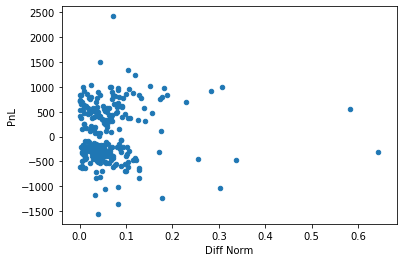

In [447]:
tradeData.plot.scatter(x='Diff Norm', y='PnL')

Slope: 481.43
Intercept: 25.23
R-Squared: 0.06


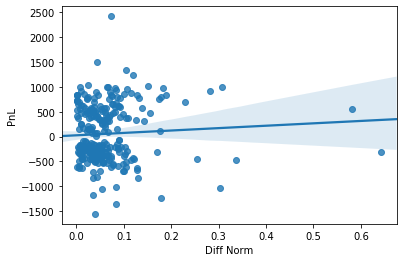

In [448]:
x = tradeData['Diff Norm']
y = tradeData['PnL']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print('Slope: {:.2f}'.format(slope))
print('Intercept: {:.2f}'.format(intercept))
print('R-Squared: {:.2f}'.format(r_value))

sns.regplot(x, y)

Slope: 4249.19
Intercept: -64.90
R-Squared: 0.12


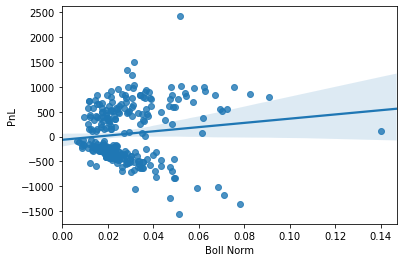

In [449]:
x = tradeData['Boll Norm']
y = tradeData['PnL']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print('Slope: {:.2f}'.format(slope))
print('Intercept: {:.2f}'.format(intercept))
print('R-Squared: {:.2f}'.format(r_value))

sns.regplot(x, y)

Slope: 22.10
Intercept: -35.86
R-Squared: 0.14


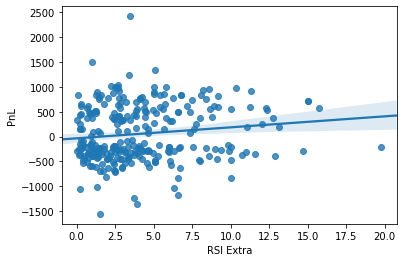

In [450]:
x = tradeData['RSI Extra']
y = tradeData['PnL']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print('Slope: {:.2f}'.format(slope))
print('Intercept: {:.2f}'.format(intercept))
print('R-Squared: {:.2f}'.format(r_value))

sns.regplot(x, y)

***
## W/L Prediction Model

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier as frst
from sklearn.tree import DecisionTreeClassifier as tr
from sklearn.linear_model import LogisticRegression as LogReg
import statsmodels.api as sm

from scipy import stats

In [452]:
forModel = tradeData[['Description', 'Ticker', 'Diff Norm', 'Boll Norm', 'RSI Extra', 'WL']]
forModel['WL2'] = forModel['WL'].apply(lambda x: 1 if x=='W' else 0)
forModel.drop(columns = ['WL'], inplace=True)
forModel.rename(columns = {'WL2':'WL'}, inplace=True)

forModel.drop(columns = ['Diff Norm', 'RSI Extra'], inplace=True)
x = forModel.iloc[:,2:-1]
y = forModel.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(*

## Logistic Regression

In [453]:
lm = sm.OLS(y_train, sm.add_constant(x_train)).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                     WL   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     11.63
Date:                Wed, 03 Jun 2020   Prob (F-statistic):           0.000795
Time:                        14:56:16   Log-Likelihood:                -130.06
No. Observations:                 188   AIC:                             264.1
Df Residuals:                     186   BIC:                             270.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2335      0.075      3.129      0.0

C:\Users\joepo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [27]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import roc_auc_score as ra

In [33]:
def score(actual, pred, pos, neg):
    matrix = cm(actual, pred, labels = [pos, neg])
    tp, fn, fp, tn = matrix.ravel()
    precision = tp / (tp + fp) # p(correct | predict pos)
    recall = tp / (tp + fn) # p(correct | actual pos)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f = (2*recall*precision) / (recall + precision)
    fpr = fp / (tn + fp)
    aucroc = ra(actual, pred)
    
    print('Accuracy:\t{:.1f}%'.format(accuracy * 100.0))
    print('Precision:\t{:.3f}'.format(precision))
    print('Recall:\t\t{:.3f}'.format(recall))
    print('F-Score:\t{:.3f}'.format(f))
    print('AUC-ROC Score:\t{:.3f}'.format(aucroc))
    print('FPR:\t\t{:.2f}%'.format(fpr * 100.0))
    print('\n\n')
    
    print('Actual (side) vs. Predicted (top)')
    print('\t|  {}  \t|  {}  \t|'.format(pos, neg))
    print('-------------------------')
    print('  {}  \t|  {} \t|  {} \t|'.format(pos, tp, fn))
    print('-------------------------')
    print('  {}  \t|  {} \t|  {} \t|'.format(neg, fp, tn))

In [456]:
model = LogReg()
model.fit(x_train, y_train)

C:\Users\joepo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [457]:
score(y_train, model.predict(x_train), 1, 0)

Accuracy:	54.3%
Precision:	nan
Recall:		0.000
F-Score:	nan
AUC-ROC Score:	0.500
FPR:		0.00%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  0 	|  86 	|
-------------------------
  0  	|  0 	|  102 	|


C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  after removing the cwd from sys.path.


In [458]:
score(y_test, model.predict(x_test), 1, 0)

Accuracy:	52.7%
Precision:	nan
Recall:		0.000
F-Score:	nan
AUC-ROC Score:	0.500
FPR:		0.00%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  0 	|  44 	|
-------------------------
  0  	|  0 	|  49 	|


C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  after removing the cwd from sys.path.


This model sucks

***
## Random Forest

Version 1

In [30]:
forModel = tradeData[['Description', 'Ticker', 'Diff Norm', 'Boll Norm', 'RSI Extra', 'WL']]
forModel['WL2'] = forModel['WL'].apply(lambda x: 1 if x=='W' else 0)
forModel.drop(columns = ['WL'], inplace=True)
forModel.rename(columns = {'WL2':'WL'}, inplace=True)

x = forModel.iloc[:,2:-1]
y = forModel.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(*

In [34]:
forest = frst(random_state=1, max_depth = 4
                             ,min_samples_split = 10
                             ,min_samples_leaf = 4)
forest.fit(x_train, y_train)

#feature importance
features = pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(forest.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')


     variable  importance
1  Boll Norm     0.48408
0  Diff Norm     0.31765
2  RSI Extra     0.19827 



C:\Users\joepo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [35]:
score(y_train, forest.predict(x_train), 1, 0)

Accuracy:	74.5%
Precision:	0.738
Recall:		0.686
F-Score:	0.711
AUC-ROC Score:	0.740
FPR:		20.59%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  59 	|  27 	|
-------------------------
  0  	|  21 	|  81 	|


In [36]:
score(y_test, forest.predict(x_test), 1, 0)

Accuracy:	64.5%
Precision:	0.634
Recall:		0.591
F-Score:	0.612
AUC-ROC Score:	0.642
FPR:		30.61%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  26 	|  18 	|
-------------------------
  0  	|  15 	|  34 	|


****Overfitting the training set just a bit****

In [463]:
# save the model to disk
filename = 'mean revert random forest.sav'
pickle.dump(forest, open(os.path.join(supp_path, filename), 'wb'))

Version 2 (ADX, CMF, OBV added)

In [37]:
forModel = tradeData[['Description', 'Ticker', 'Diff Norm', 'Boll Norm', 'RSI Extra'
                      , 'ADX', 'CMF', 'OBV Change', 'OBV Change Abs.', 'WL']]
forModel['WL2'] = forModel['WL'].apply(lambda x: 1 if x=='W' else 0)
forModel.drop(columns = ['WL'], inplace=True)
forModel.rename(columns = {'WL2':'WL'}, inplace=True)

x = forModel.iloc[:,2:-1]
y = forModel.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/us

In [38]:
forest = frst(random_state=1, max_depth = 4
                             ,min_samples_split = 10
                             ,min_samples_leaf = 4)
forest.fit(x_train, y_train)

#feature importance
features = pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(forest.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')


           variable  importance
4              CMF    0.265473
1        Boll Norm    0.174437
2        RSI Extra    0.147061
0        Diff Norm    0.137283
6  OBV Change Abs.    0.118360
5       OBV Change    0.102681
3              ADX    0.054705 



C:\Users\joepo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [39]:
score(y_train, forest.predict(x_train), 1, 0)

Accuracy:	82.4%
Precision:	0.873
Recall:		0.721
F-Score:	0.790
AUC-ROC Score:	0.816
FPR:		8.82%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  62 	|  24 	|
-------------------------
  0  	|  9 	|  93 	|


In [40]:
score(y_test, forest.predict(x_test), 1, 0)

Accuracy:	50.5%
Precision:	0.475
Recall:		0.432
F-Score:	0.452
AUC-ROC Score:	0.502
FPR:		42.86%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  19 	|  25 	|
-------------------------
  0  	|  21 	|  28 	|


****Overfits too much****

***
## Decision Tree

Version 1

In [464]:
forModel = tradeData[['Description', 'Ticker', 'Diff Norm', 'Boll Norm', 'RSI Extra', 'WL']]
forModel['WL2'] = forModel['WL'].apply(lambda x: 1 if x=='W' else 0)
forModel.drop(columns = ['WL'], inplace=True)
forModel.rename(columns = {'WL2':'WL'}, inplace=True)

x = forModel.iloc[:,2:-1]
y = forModel.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(*

In [465]:
tree = tr(max_depth = 3, min_samples_split = 10, min_samples_leaf = 4)
tree.fit(x_train, y_train)

#feature importance
features = pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(tree.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')


     variable  importance
1  Boll Norm    0.622298
0  Diff Norm    0.377702
2  RSI Extra    0.000000 



In [466]:
score(y_train, tree.predict(x_train), 1, 0)

Accuracy:	68.1%
Precision:	0.671
Recall:		0.593
F-Score:	0.630
AUC-ROC Score:	0.674
FPR:		24.51%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  51 	|  35 	|
-------------------------
  0  	|  25 	|  77 	|


In [467]:
score(y_test, tree.predict(x_test), 1, 0)

Accuracy:	59.1%
Precision:	0.579
Recall:		0.500
F-Score:	0.537
AUC-ROC Score:	0.587
FPR:		32.65%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  22 	|  22 	|
-------------------------
  0  	|  16 	|  33 	|


#### Doesn't over quite as badly (9% drop vs 10% drop), but lots of false positives

Version 2 (ADX, CMF, OBV added)

In [44]:
forModel = tradeData[['Description', 'Ticker', 'Diff Norm', 'Boll Norm', 'RSI Extra'
                      , 'ADX', 'CMF', 'OBV Change', 'OBV Change Abs.', 'WL']]
forModel['WL2'] = forModel['WL'].apply(lambda x: 1 if x=='W' else 0)
forModel.drop(columns = ['WL'], inplace=True)
forModel.rename(columns = {'WL2':'WL'}, inplace=True)

x = forModel.iloc[:,2:-1]
y = forModel.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/us

In [45]:
tree = tr(max_depth = 3, min_samples_split = 10, min_samples_leaf = 4)
tree.fit(x_train, y_train)

#feature importance
features = pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(tree.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')


           variable  importance
3              ADX    0.399446
1        Boll Norm    0.289111
4              CMF    0.189929
5       OBV Change    0.121513
0        Diff Norm    0.000000
2        RSI Extra    0.000000
6  OBV Change Abs.    0.000000 



In [54]:
forModel = tradeData[['Description', 'Ticker', 'Diff Norm', 'Boll Norm', 'RSI Extra'
                      , 'ADX', 'CMF', 'OBV Change', 'OBV Change Abs.', 'WL']]
forModel['WL2'] = forModel['WL'].apply(lambda x: 1 if x=='W' else 0)
forModel.drop(columns = ['WL'], inplace=True)
forModel.rename(columns = {'WL2':'WL'}, inplace=True)

forModel.drop(columns = ['Diff Norm', 'RSI Extra', 'OBV Change Abs.'], inplace=True)

x = forModel.iloc[:,2:-1]
y = forModel.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
tree = tr(max_depth = 3, min_samples_split = 10, min_samples_leaf = 4)
tree.fit(x_train, y_train)

#feature importance
features = pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(tree.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')


      variable  importance
1         ADX    0.399446
0   Boll Norm    0.289111
2         CMF    0.189929
3  OBV Change    0.121513 



In [48]:
score(y_train, tree.predict(x_train), 1, 0)

Accuracy:	71.8%
Precision:	0.732
Recall:		0.605
F-Score:	0.662
AUC-ROC Score:	0.709
FPR:		18.63%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  52 	|  34 	|
-------------------------
  0  	|  19 	|  83 	|


In [49]:
score(y_test, tree.predict(x_test), 1, 0)

Accuracy:	59.1%
Precision:	0.583
Recall:		0.477
F-Score:	0.525
AUC-ROC Score:	0.586
FPR:		30.61%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  21 	|  23 	|
-------------------------
  0  	|  15 	|  34 	|


In [50]:
# save the model to disk
filename = 'mean revert dec tree.v2.sav'
pickle.dump(tree, open(os.path.join(supp_path, filename), 'wb'))

***

Try to predict PnL

In [468]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.ensemble import RandomForestRegressor as rfReg
from sklearn.tree import DecisionTreeRegressor as trReg
import statsmodels.api as sm
from scipy import stats

## Linear Regression

In [469]:
forModel = tradeData[['PnL', 'Diff Norm', 'Boll Norm', 'RSI Extra']]

forModel.drop(columns=[], inplace=True)
x = forModel.iloc[:,1:]
y = forModel.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [470]:
lm = sm.OLS(y_train, sm.add_constant(x_train)).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    PnL   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.852
Date:                Wed, 03 Jun 2020   Prob (F-statistic):              0.139
Time:                        14:56:16   Log-Likelihood:                -1459.9
No. Observations:                 188   AIC:                             2928.
Df Residuals:                     184   BIC:                             2941.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -140.6317     99.631     -1.412      0.1

C:\Users\joepo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Nope

***
## Decision Tree

In [471]:
from sklearn.metrics import r2_score as rsq
from sklearn.metrics import mean_squared_error as mse

In [472]:
forModel = tradeData[['PnL', 'Diff Norm', 'Boll Norm', 'RSI Extra']]

x = forModel.iloc[:,1:]
y = forModel.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [473]:
tree = trReg(max_depth = 4, min_samples_split = 10, min_samples_leaf = 4)
tree.fit(x_train, y_train)

#feature importance
features = pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(tree.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')


     variable  importance
1  Boll Norm    0.559929
0  Diff Norm    0.409417
2  RSI Extra    0.030654 



In [474]:
train_pred = tree.predict(x_train)
print(mse(y_train, train_pred))
print(rsq(y_train, train_pred))

all = pd.concat((pd.DataFrame(y_train), pd.DataFrame(train_pred)), axis = 1)
all.columns = ['PnL', 'Pred']

all['actual'] = all['PnL'].apply(lambda x: 1 if x > 0 else 0)
all['predicted'] = all['Pred'].apply(lambda x: 1 if x > 0 else 0)

score(all['actual'], all['predicted'], 1, 0)

242380.6565111652
0.2772474746996446
Accuracy:	69.1%
Precision:	0.792
Recall:		0.442
F-Score:	0.567
AUC-ROC Score:	0.672
FPR:		9.80%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  38 	|  48 	|
-------------------------
  0  	|  10 	|  92 	|


In [475]:
test_pred = tree.predict(x_test)
print(mse(y_test, test_pred))
print(rsq(y_test, test_pred))

all = pd.concat((pd.DataFrame(y_test), pd.DataFrame(test_pred)), axis=1)
all.columns = ['PnL', 'Pred']

all['actual'] = all['PnL'].apply(lambda x: 1 if x > 0 else 0)
all['predicted'] = all['Pred'].apply(lambda x: 1 if x > 0 else 0)

score(all['actual'], all['predicted'], 1, 0)

430890.5975671514
-0.5737558451803322
Accuracy:	53.8%
Precision:	0.517
Recall:		0.341
F-Score:	0.411
AUC-ROC Score:	0.528
FPR:		28.57%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  15 	|  29 	|
-------------------------
  0  	|  14 	|  35 	|


****Big dropoff in accuracy and FPR between train and test****

***
## Random Forest

In [476]:
forModel = tradeData[['PnL', 'Diff Norm', 'Boll Norm', 'RSI Extra']]

x = forModel.iloc[:,1:]
y = forModel.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [477]:
forest = rfReg(random_state=1, max_depth = 4
                             ,min_samples_split = 10
                             ,min_samples_leaf = 4)
forest.fit(x_train, y_train)

#feature importance
features = pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(forest.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')


     variable  importance
1  Boll Norm    0.498436
0  Diff Norm    0.327884
2  RSI Extra    0.173679 



C:\Users\joepo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [478]:
train_pred = forest.predict(x_train)
print(mse(y_train, train_pred))
print(rsq(y_train, train_pred))

all = pd.concat((pd.DataFrame(y_train), pd.DataFrame(train_pred)), axis = 1)
all.columns = ['PnL', 'Pred']

all['actual'] = all['PnL'].apply(lambda x: 1 if x > 0 else 0)
all['predicted'] = all['Pred'].apply(lambda x: 1 if x > 0 else 0)

score(all['actual'], all['predicted'], 1, 0)

243336.285110731
0.27439789506104173
Accuracy:	69.7%
Precision:	0.628
Recall:		0.826
F-Score:	0.714
AUC-ROC Score:	0.707
FPR:		41.18%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  71 	|  15 	|
-------------------------
  0  	|  42 	|  60 	|


In [479]:
test_pred = forest.predict(x_test)
print(mse(y_test, test_pred))
print(rsq(y_test, test_pred))

all = pd.concat((pd.DataFrame(y_test), pd.DataFrame(test_pred)), axis=1)
all.columns = ['PnL', 'Pred']

all['actual'] = all['PnL'].apply(lambda x: 1 if x > 0 else 0)
all['predicted'] = all['Pred'].apply(lambda x: 1 if x > 0 else 0)

score(all['actual'], all['predicted'], 1, 0)

286658.6701085575
-0.04697285158248854
Accuracy:	57.0%
Precision:	0.536
Recall:		0.682
F-Score:	0.600
AUC-ROC Score:	0.576
FPR:		53.06%



Actual (side) vs. Predicted (top)
	|  1  	|  0  	|
-------------------------
  1  	|  30 	|  14 	|
-------------------------
  0  	|  26 	|  23 	|


****Again, large dropoff between train and test****

***
***
## OOS Testing

### Double sizing if long

In [480]:
class live_model_long_double_size(bt.Strategy):
    '''
    SMA mean reverting
    '''
    params = dict(
        sizingPerc = 0.01
        ,fastSMA = 20
        ,slowSMA = 100
        ,bollStd = 1
        ,rangeLow = 1.75
        ,rangeHigh = 2.25
        ,stopRange = 2.5
        ,resetRange = 1.5
        ,rsiBound = 20
        ,rsiClose = 5
        ,rsiPeriod = 14
        ,profitTake = 0.1
        ,printLog = True
        )

    def __init__(self):
        self.startCash = None
        self.order = {}
        self.stoploss = {}
        self.fastSlow = {}
        self.smaCrosses = {}
        self.distInRange = {}
        self.revertEarly = {}
        self.rsiCross = {}
        self.ls = {}
        self.highStop = {}
        self.lowStop = {}
        self.tradedata = {}
        self.reldata = {}
        self.price = {}
        self.inds = {}
        for i, d in enumerate(self.datas):
            self.order[d] = None
            self.stoploss[d] = None
            self.fastSlow[d] = None
            self.smaCrosses[d] = 0
            self.distInRange[d] = False
            self.revertEarly[d] = False
            self.rsiCross[d] = None
            self.ls[d] = 0
            self.highStop[d] = 0
            self.lowStop[d] = 0
            self.reldata[d] = []
            self.price[d] = 0
            self.inds[d] = {}
            self.inds[d]['sma fast'] = bt.ind.SMA(d.close, period = self.p.fastSMA).lines.sma
            self.inds[d]['sma slow'] = bt.ind.SMA(d.close, period = self.p.slowSMA).lines.sma
            self.inds[d]['bands'] = bt.ind.BBands(d.close, period = self.p.fastSMA, devfactor = self.p.bollStd, plot=False)
            self.inds[d]['band diff'] = self.inds[d]['bands'].lines.top - self.inds[d]['bands'].lines.mid
            self.inds[d]['rsi'] = bt.ind.RSI_SMA(d.close, period = self.p.rsiPeriod).lines.rsi
            self.inds[d]['rsi buy'] = bt.ind.CrossDown(self.inds[d]['rsi'], 50 - self.p.rsiBound, plot=False)
            self.inds[d]['rsi sell'] = bt.ind.CrossUp(self.inds[d]['rsi'], 50 + self.p.rsiBound, plot=False)
            self.inds[d]['rsi close long'] = bt.ind.CrossUp(self.inds[d]['rsi'], 50 + self.p.rsiClose, plot=False)
            self.inds[d]['rsi close short'] = bt.ind.CrossDown(self.inds[d]['rsi'], 50 - self.p.rsiClose, plot=False)

    def start(self):
        self.startCash = self.broker.getvalue()
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            d = order.data
            if order.isbuy():
                bs = "Bought"
                self.ls[d] = 1
            else:
                bs = "Sold"
                self.ls[d] = -1
            desc = "{} {} shares of {} for ${:.2f}".format(bs, order.executed.size, d._name, order.executed.price)
            self.log(desc)
            self.price[d] = order.executed.price
            if len(self.reldata[d]) == 12:
                self.reldata[d].append('Stop')
            self.reldata[d].append(desc)
        elif order.status in [order.Canceled]:
            self.log('Order Canceled for {}'.format(order.data._name))
        elif order.status in [order.Margin, order.Rejected]:
            self.log('Order rejected or margin issue')

    def notify_trade(self, trade):
        d = trade.data
        if not trade.isclosed:
            return
        self.reldata[d].append(trade.pnlcomm)
        self.tradedata[self.reldata[d][11]] = self.reldata[d]
        self.cancel(self.stoploss[d])
        self.stoploss[d] = None
        self.resetBools(d)

    def resetBools(self, t):
        self.fastSlow[t] = None
        self.smaCrosses[t] = 0
        self.distInRange[t] = False
        self.revertEarly[t] = False
        self.rsiCross[t] = None
        self.ls[t] = 0
        self.reldata[t] = []
        self.price[t] = 0

    def log(self, txt, dp=False):
        if self.p.printLog or dp:
            date = self.datas[0].datetime.date(0)
            print("{}: {}".format(date, txt))

    def sizingCalc(self, capital, price, half=False):
        available = float(capital) * self.p.sizingPerc
        if half:
            inter = available/price
            shares = round(inter/2.0)
        else:
            shares = round(available/price)
        return shares

    def awayThreshold(self, thresh, fast, close, ab):
        if ab == "Above":
            new = float(fast) * (1 + float(thresh))
            if float(close) > new:
                return True
            else:
                return False
        elif ab == "Below":
            new = float(fast) * (1 - float(thresh))
            if float(close) < new:
                return True
            else:
                return False
        else:
            self.log("awayThreshold:  We have a problem: {}".format(ab))

    def resetAway(self, reset, fast, close, ab):
        if ab == "Above":
            new = float(fast) * (1 + float(reset))
            if float(close) > new:
                return True
            else:
                return False
        elif ab == "Below":
            new = float(fast) * (1 - float(reset))
            if float(close) < new:
                return True
            else:
                return False

    def next(self):
        for i, d in enumerate(self.datas):
            fast = self.inds[d]['sma fast'][0]
            slow = self.inds[d]['sma slow'][0]
            bollWidth = self.inds[d]['band diff'][0]
            rsi = self.inds[d]['rsi'][0]
            close = d.close[0]
            ticker = d._name
            if self.getposition(d).size == 0: ##not in market
                if fast > slow: ##fast above slow ma
                    self.fastSlow[d] = "Above"
                    if self.distInRange[d]:
                        if close < fast + (bollWidth * self.p.resetRange):
                            ##fell out of range
                            self.distInRange[d] = False
                        else:
                            ##still in range
                            if self.inds[d]['rsi sell'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close, half=True)
                                self.order[d] = self.sell(data=d, size=numShares)
                                self.log("Sell {} shares of {}".format(numShares, ticker))
                                #self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append(rsi - (50 + self.p.rsiBound))
                    else:
                        lowRange = bollWidth * self.p.rangeLow
                        highRange = bollWidth * self.p.rangeHigh
                        if close > (fast + lowRange) and close < (fast + highRange):
                            self.distInRange[d] = True
                            if self.inds[d]['rsi sell'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close, half=True)
                                self.order[d] = self.sell(data=d, size=numShares)
                                self.log("Sell {} shares of {}".format(numShares, ticker))
                                #self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append(rsi - (50 + self.p.rsiBound))

                elif fast < slow: ##fast below slow sma
                    self.fastSlow[d] = "Below"
                    if self.distInRange[d]:
                        if close > fast - (bollWidth * self.p.resetRange):
                            ##fell out of range
                            self.distInRange[d] = False
                        else:
                            ##still in range
                            if self.inds[d]['rsi buy'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.buy(data=d, size = numShares)
                                self.log("Buy {} shares of {}".format(numShares, ticker))
                                #self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append((50 - self.p.rsiBound) - rsi)
                    else:
                        lowRange = bollWidth * self.p.rangeLow
                        highRange = bollWidth * self.p.rangeHigh
                        if close > (fast - highRange) and close < (fast - lowRange):
                            self.distInRange[d] = True
                            if self.inds[d]['rsi buy'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.buy(data=d, size = numShares)
                                self.log("Buy {} shares of {}".format(numShares, ticker))
                                #self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append((50 - self.p.rsiBound) - rsi)

            else:
                if self.ls[d] < 0: ##sold
                    if self.stoploss[d] is None:
                        self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price=self.highStop[d]
                                                      )
                        self.log("Buy stop created at ${:.2f} for {}".format(
                            self.highStop[d], ticker))
                    ##check for rsi cross
                    if close < self.price[d] * (1-self.p.profitTake):
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("Take {}% profit and close {}".format(self.p.profitTake*100.0, ticker))
                        self.reldata[d].append('Profit')
                    elif self.inds[d]['rsi close short'].lines.cross[0] > 0:
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("RSI broke below for {}, close position".format(ticker))
                        self.reldata[d].append('RSI')
                    ##check for number of sma crosses #starts above
                    elif self.smaCrosses[d] == 0:
                        ##check for sma cross below
                        if fast < slow:
                            self.smaCrosses[d] = 1
                    elif self.smaCrosses[d] == 1:
                        if fast > slow:
                            ##sma crossed back above, exit short position
                            self.order[d] = self.close(data=d)
                            self.cancel(self.stoploss[d])
                            self.log("Upward momentum with SMA crossing up for {}, close position".format(ticker))
                            self.reldata[d].append('SMA Cross')
                else:  ##bought
                    if self.stoploss[d] is None:
                        self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price=self.lowStop[d]
                                                      )
                        self.log("Sell stop created at ${:.2f} for {}".format(
                            self.lowStop[d], ticker))
                    if close > self.price[d] * (1+self.p.profitTake):
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("Take {}% profit and close {}".format(self.p.profitTake*100.0, ticker))
                        self.reldata[d].append('Profit')
                    ##check for rsi cross
                    elif self.inds[d]['rsi close long'].lines.cross[0] > 0:
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("RSI broke above for {}, close position".format(ticker))
                        self.reldata[d].append('RSI')
                    elif self.smaCrosses[d] == 0:
                        ##check for sma cross above
                        if fast > slow:
                            self.smaCrosses[d] = 1
                    elif self.smaCrosses[d] == 1:
                        if fast < slow:
                            ##sma crossed back below, exit long position
                            self.order[d] = self.close(data=d)
                            self.cancel(self.stoploss[d])
                            self.log("Downard momentum with SMA crossing down for {}, close position".format(ticker))
                            self.reldata[d].append('SMA Cross')
                        
    def stop(self):
        pnl = self.broker.getvalue() - self.startCash
        print("\n\n ------- Final Analysis ------- ")
        print("Ending Value: ${:.2f}\nP&L:  ${:.2f}\n".format(self.broker.getvalue(), pnl))

In [481]:
allData = []
pnls = []
for t in allTickersOOS:
    print(t)
    cerebro = bt.Cerebro()
    data = bt.feeds.GenericCSVData(dataname = os.path.join(outPath, t + '.csv')
                                   ,fromdate = start_test_dt
                                   ,todate = end_test_dt
                                   ,nullvalue = 0.0
                                   ,dtformat = datedict[iterator]
                                   ,datetime = 0
                                   ,high = 2
                                   ,low = 3
                                   ,open = 1
                                   ,close = 4
                                   ,volume = 6
                                   ,openinterest = -1 #no open interest column
                                   )
    cerebro.adddata(data, name=t)
    
    cerebro.broker.set_cash(startingcash)
    print("Running with ${} as starting cash".format(startingcash))
    print("Trading {:.2f}% of portfolio value".format(sizingperc * 100.0))
    cerebro.addstrategy(live_model_long_double_size
                    ,sizingPerc = sizingperc
                    ,fastSMA = fast_sma
                    ,slowSMA = slow_sma
                    ,bollStd = boll_std
                    ,rangeLow = range_dist_min
                    ,rangeHigh = range_dist_max
                    ,stopRange = exit_dist
                    ,resetRange = reset_dist
                    ,rsiBound = rsi_thresh
                    ,rsiClose = rsi_close
                    ,rsiPeriod = rsi_period
                    ,profitTake = profit
                    ,printLog = False
                    )
    
    #add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='annRets')
    cerebro.addanalyzer(custom_analyzer, _name='tradeDict')
    cerebro.addanalyzer(custom_analyzer2, _name='pnl')
    
    #run backtest
    test = cerebro.run()
    analysis = test[0]
    
    #get analyzers
    sharpe = analysis.analyzers.sharpe.get_analysis()
    sqn = analysis.analyzers.sqn.get_analysis()
    rets = analysis.analyzers.annRets.get_analysis()
    trade = analysis.analyzers.trades.get_analysis()
    trades = analysis.analyzers.tradeDict.get_analysis()
    pl = analysis.analyzers.pnl.get_analysis()
    
    #print analysis
    #print(ma.main_analysis(sharpe, sqn, rets))
    
    allData.append(trades)
    pnls.append(pl)

ABT
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200121.50
P&L:  $121.50

ATVI
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200184.49
P&L:  $184.49

CSCO
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200000.00
P&L:  $0.00

CVS
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200376.98
P&L:  $376.98

LOW
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $202217.94
P&L:  $2217.94

NKE
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $202194.28
P&L:  $2194.28

SBUX
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analy

In [482]:
sum(pnls)

8609.950174298574

In [483]:
dfs = []
cols = ['Ticker', 'Fast SMA', 'Slow SMA', 'SMA Diff', 'Bollinger Width', 'RSI'
       , 'Fast Norm', 'Slow Norm', 'Diff Norm', 'Boll Norm', 'RSI Extra', 'Entry Desc'
       , 'Reason', 'Exit Desc', 'PnL']
for d in allData:
    df = pd.DataFrame.from_dict(d, orient='index', columns=cols).reset_index()
    dfs.append(df)
    
tradeData = pd.concat(dfs).reset_index(drop=True)
tradeData.rename({'index':'Description'}, axis=1, inplace=True)
tradeData['WL'] = tradeData['PnL'].apply(lambda x: 'W' if x > 0 else 'L')
tradeData['LS'] = tradeData['Description'].apply(lambda x: 'Long' if x.split(' ')[0] == 'Bought' else 'Short')
tradeData

Description Ticker     Fast SMA     Slow SMA  \
0      Sold -54 shares of ABT for $91.81    ABT    87.156500    84.262300   
1     Sold -79 shares of ATVI for $63.36   ATVI    60.521000    56.766400   
2     Sold -75 shares of ATVI for $66.98   ATVI    61.631500    59.416300   
3    Bought 183 shares of CVS for $57.46    CVS    65.247001    70.831700   
4     Sold -40 shares of LOW for $122.32    LOW   121.859000   116.776700   
5    Bought 138 shares of LOW for $73.55    LOW   108.479000   115.962400   
6     Sold -49 shares of NKE for $103.25    NKE   101.072500    92.984300   
7    Bought 148 shares of NKE for $65.00    NKE    83.186500    94.757300   
8     Sold -54 shares of SBUX for $92.93   SBUX    89.161000    87.636499   
9   Bought 132 shares of SBUX for $73.46   SBUX    84.583000    86.158899   
10  Bought 170 shares of SBUX for $59.55   SBUX    77.811000    84.920299   
11     Bought 319 shares of T for $32.92      T    36.806500    38.060300   
12     Bought 355 shares of T for $28.08      T    33.882000    37.504700   
13     Sold -81 shares of DAL for $61.25    DAL    59.430500    57.037700   
14  Bought 1653 shares of SIRI for $5.66   SIRI     6.775500     6.907000   
15  Bought 2243 shares of SIRI for $4.38   SIRI     6.037000     6.815700   
16   Bought 227 shares of WFC for $43.32    WFC    47.264500    51.066700   
17   Bought 376 shares of WFC for $26.26    WFC    35.808500    48.436300   
18   Sold -4 shares of GOOG for $1427.56   GOOG  1361.762000  1271.546005   
19   Bought 3509 shares of GME for $2.85    GME     3.945000     4.854100   
20     Sold -238 shares of LB for $21.09     LB    19.089000    18.171300   
21     Sold -210 shares of LB for $23.98     LB    20.688500    18.575500   
22   Bought 324 shares of LUV for $32.06    LUV    44.144500    53.690800   
23   Bought 433 shares of AAL for $23.57    AAL    27.994000    28.285900   
24     Sold -20 shares of HD for $244.84     HD   235.769499   228.026199   
25    Bought 66 shares of HD for $150.06     HD   208.501500   223.901800   
26    Sold -39 shares of WMT for $129.00    WMT   118.497500   117.266100   
27     Sold -539 shares of BCS for $8.72    BCS     9.037000     8.811900   
28    Bought 35 shares of BA for $278.07     BA   328.116000   343.059200   
29     Bought 243 shares of C for $42.00      C    63.318500    74.100300   
30   Bought 105 shares of DIS for $95.80    DIS   118.777500   137.764799   
31      Sold -88 shares of KO for $56.85     KO    55.044000    54.128500   
32      Sold -83 shares of KO for $59.81     KO    58.437500    54.907400   
33    Bought 261 shares of KO for $38.76     KO    51.808500    54.701500   
34      Sold -292 shares of M for $17.40      M    16.136000    15.703100   
35   Sold -31 shares of MSFT for $162.82   MSFT   157.146000   144.906500   
36   Sold -30 shares of MSFT for $167.40   MSFT   160.642500   146.835300   
37   Sold -28 shares of MSFT for $184.03   MSFT   166.010499   150.002000   
38   Sold -17 shares of NVDA for $285.64   NVDA   253.732500   219.385600   
39   Sold -13 shares of NFLX for $377.18   NFLX   351.273502   308.020999   
40   Sold -12 shares of NFLX for $437.00   NFLX   366.694997   345.538499   
41   Sold -156 shares of PENN for $32.78   PENN    27.215000    23.004800   
42    Sold -52 shares of QCOM for $95.33   QCOM    89.369500    82.907300   
43  Bought 138 shares of QCOM for $74.80   QCOM    83.634000    86.030700   
44   Bought 104 shares of RCL for $97.78    RCL   113.920001   118.494900   
45   Bought 130 shares of USO for $74.08    USO    83.699999    93.337600   
46      Sold -26 shares of V for $193.50      V   187.684500   180.102800   
47    Bought 182 shares of VZ for $53.74     VZ    58.385000    59.879800   
48    Bought 180 shares of VZ for $56.22     VZ    57.288500    57.628500   
49   Bought 227 shares of WFC for $43.32    WFC    47.264500    51.066700   
50   Bought 376 shares of WFC for $26.26    WFC    35.808500    48.436300   
51     Bought 1005 shares

In [484]:
tradeData['WL'].value_counts()

W    28
L    26
Name: WL, dtype: int64

In [485]:
tradeData.groupby(['WL'])['PnL'].mean()

WL
L   -615.632328
W    845.690355
Name: PnL, dtype: float64

In [486]:
tradeData.groupby(['WL'])['PnL'].std()

WL
L    620.726785
W    715.083078
Name: PnL, dtype: float64

In [487]:
tradeData.groupby(['Reason', 'WL'])['Ticker'].count().unstack()

WL         L     W
Reason            
Profit   NaN  21.0
RSI      NaN   7.0
Stop    26.0   NaN

In [488]:
grouped = tradeData.groupby(['LS', 'WL'])['Ticker'].count().unstack()
grouped['Total'] = grouped['L'] + grouped['W']
grouped['P(W)'] = grouped['W'] / grouped['Total']
grouped

WL      L   W  Total      P(W)
LS                            
Long   14  15     29  0.517241
Short  12  13     25  0.520000

In [489]:
tradeData.groupby(['LS'])['Reason'].value_counts(normalize=True).unstack()

Reason    Profit       RSI      Stop
LS                                  
Long    0.482759  0.034483  0.482759
Short   0.280000  0.240000  0.480000

****OOS testing implies difficulty with shorting from training isn't always case****

***
### Double Sizing if model predicts profitable

In [490]:
class live_model_rf_double_size(bt.Strategy):
    '''
    SMA mean reverting
    '''
    params = dict(
        sizingPerc = 0.01
        ,fastSMA = 20
        ,slowSMA = 100
        ,bollStd = 1
        ,rangeLow = 1.75
        ,rangeHigh = 2.25
        ,stopRange = 2.5
        ,resetRange = 1.5
        ,rsiBound = 20
        ,rsiClose = 5
        ,rsiPeriod = 14
        ,profitTake = 0.1
        ,mod = None
        ,printLog = True
        )

    def __init__(self):
        self.startCash = None
        self.order = {}
        self.stoploss = {}
        self.fastSlow = {}
        self.smaCrosses = {}
        self.distInRange = {}
        self.revertEarly = {}
        self.rsiCross = {}
        self.ls = {}
        self.highStop = {}
        self.lowStop = {}
        self.tradedata = {}
        self.reldata = {}
        self.price = {}
        self.inds = {}
        for i, d in enumerate(self.datas):
            self.order[d] = None
            self.stoploss[d] = None
            self.fastSlow[d] = None
            self.smaCrosses[d] = 0
            self.distInRange[d] = False
            self.revertEarly[d] = False
            self.rsiCross[d] = None
            self.ls[d] = 0
            self.highStop[d] = 0
            self.lowStop[d] = 0
            self.reldata[d] = []
            self.price[d] = 0
            self.inds[d] = {}
            self.inds[d]['sma fast'] = bt.ind.SMA(d.close, period = self.p.fastSMA).lines.sma
            self.inds[d]['sma slow'] = bt.ind.SMA(d.close, period = self.p.slowSMA).lines.sma
            self.inds[d]['bands'] = bt.ind.BBands(d.close, period = self.p.fastSMA, devfactor = self.p.bollStd, plot=False)
            self.inds[d]['band diff'] = self.inds[d]['bands'].lines.top - self.inds[d]['bands'].lines.mid
            self.inds[d]['rsi'] = bt.ind.RSI_SMA(d.close, period = self.p.rsiPeriod).lines.rsi
            self.inds[d]['rsi buy'] = bt.ind.CrossDown(self.inds[d]['rsi'], 50 - self.p.rsiBound, plot=False)
            self.inds[d]['rsi sell'] = bt.ind.CrossUp(self.inds[d]['rsi'], 50 + self.p.rsiBound, plot=False)
            self.inds[d]['rsi close long'] = bt.ind.CrossUp(self.inds[d]['rsi'], 50 + self.p.rsiClose, plot=False)
            self.inds[d]['rsi close short'] = bt.ind.CrossDown(self.inds[d]['rsi'], 50 - self.p.rsiClose, plot=False)

    def start(self):
        self.startCash = self.broker.getvalue()
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            d = order.data
            if order.isbuy():
                bs = "Bought"
                self.ls[d] = 1
            else:
                bs = "Sold"
                self.ls[d] = -1
            desc = "{} {} shares of {} for ${:.2f}".format(bs, order.executed.size, d._name, order.executed.price)
            self.log(desc)
            self.price[d] = order.executed.price
            if len(self.reldata[d]) == 12:
                self.reldata[d].append('Stop')
            self.reldata[d].append(desc)
        elif order.status in [order.Canceled]:
            self.log('Order Canceled for {}'.format(order.data._name))
        elif order.status in [order.Margin, order.Rejected]:
            self.log('Order rejected or margin issue')

    def notify_trade(self, trade):
        d = trade.data
        if not trade.isclosed:
            return
        self.reldata[d].append(trade.pnlcomm)
        self.tradedata[self.reldata[d][11]] = self.reldata[d]
        self.cancel(self.stoploss[d])
        self.stoploss[d] = None
        self.resetBools(d)

    def resetBools(self, t):
        self.fastSlow[t] = None
        self.smaCrosses[t] = 0
        self.distInRange[t] = False
        self.revertEarly[t] = False
        self.rsiCross[t] = None
        self.ls[t] = 0
        self.reldata[t] = []
        self.price[t] = 0

    def log(self, txt, dp=False):
        if self.p.printLog or dp:
            date = self.datas[0].datetime.date(0)
            print("{}: {}".format(date, txt))

    def sizingCalc(self, capital, price, half=False):
        available = float(capital) * self.p.sizingPerc
        if half:
            inter = available/price
            shares = round(inter/2.0)
        else:
            shares = round(available/price)
        return shares

    def awayThreshold(self, thresh, fast, close, ab):
        if ab == "Above":
            new = float(fast) * (1 + float(thresh))
            if float(close) > new:
                return True
            else:
                return False
        elif ab == "Below":
            new = float(fast) * (1 - float(thresh))
            if float(close) < new:
                return True
            else:
                return False
        else:
            self.log("awayThreshold:  We have a problem: {}".format(ab))

    def resetAway(self, reset, fast, close, ab):
        if ab == "Above":
            new = float(fast) * (1 + float(reset))
            if float(close) > new:
                return True
            else:
                return False
        elif ab == "Below":
            new = float(fast) * (1 - float(reset))
            if float(close) < new:
                return True
            else:
                return False

    def next(self):
        for i, d in enumerate(self.datas):
            fast = self.inds[d]['sma fast'][0]
            slow = self.inds[d]['sma slow'][0]
            bollWidth = self.inds[d]['band diff'][0]
            rsi = self.inds[d]['rsi'][0]
            close = d.close[0]
            ticker = d._name
            sma_diff_norm = abs(fast-slow)/close
            boll_diff_norm = bollWidth/close
            rsi_extra = rsi - (50 + self.p.rsiBound)
            if self.getposition(d).size == 0: ##not in market
                if fast > slow: ##fast above slow ma
                    self.fastSlow[d] = "Above"
                    if self.distInRange[d]:
                        if close < fast + (bollWidth * self.p.resetRange):
                            ##fell out of range
                            self.distInRange[d] = False
                        else:
                            ##still in range
                            if self.inds[d]['rsi sell'].lines.cross[0] > 0:
                                wl = self.p.mod.predict(pd.DataFrame([[sma_diff_norm, boll_diff_norm, rsi_extra]]))[0]
                                if wl==1:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                else:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close, half=True)
                                self.order[d] = self.sell(data=d, size=numShares)
                                self.log("Sell {} shares of {}".format(numShares, ticker))
                                #self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, sma_diff_norm, boll_diff_norm])
                                self.reldata[d].append(rsi_extra)
                    else:
                        lowRange = bollWidth * self.p.rangeLow
                        highRange = bollWidth * self.p.rangeHigh
                        if close > (fast + lowRange) and close < (fast + highRange):
                            self.distInRange[d] = True
                            if self.inds[d]['rsi sell'].lines.cross[0] > 0:
                                wl = self.p.mod.predict(pd.DataFrame([[sma_diff_norm, boll_diff_norm, rsi_extra]]))[0]
                                if wl==1:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                else:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close, half=True)
                                self.order[d] = self.sell(data=d, size=numShares)
                                self.log("Sell {} shares of {}".format(numShares, ticker))
                                #self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, sma_diff_norm, boll_diff_norm])
                                self.reldata[d].append(rsi_extra)

                elif fast < slow: ##fast below slow sma
                    self.fastSlow[d] = "Below"
                    if self.distInRange[d]:
                        if close > fast - (bollWidth * self.p.resetRange):
                            ##fell out of range
                            self.distInRange[d] = False
                        else:
                            ##still in range
                            if self.inds[d]['rsi buy'].lines.cross[0] > 0:
                                wl = self.p.mod.predict(pd.DataFrame([[sma_diff_norm, boll_diff_norm, rsi_extra]]))[0]
                                if wl==1:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                else:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.buy(data=d, size = numShares)
                                self.log("Buy {} shares of {}".format(numShares, ticker))
                                #self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, sma_diff_norm, boll_diff_norm])
                                self.reldata[d].append(rsi_extra)
                    else:
                        lowRange = bollWidth * self.p.rangeLow
                        highRange = bollWidth * self.p.rangeHigh
                        if close > (fast - highRange) and close < (fast - lowRange):
                            self.distInRange[d] = True
                            if self.inds[d]['rsi buy'].lines.cross[0] > 0:
                                wl = self.p.mod.predict(pd.DataFrame([[sma_diff_norm, boll_diff_norm, rsi_extra]]))[0]
                                if wl==1:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                else:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.buy(data=d, size = numShares)
                                self.log("Buy {} shares of {}".format(numShares, ticker))
                                #self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, sma_diff_norm, boll_diff_norm])
                                self.reldata[d].append(rsi_extra)

            else:
                if self.ls[d] < 0: ##sold
                    if self.stoploss[d] is None:
                        self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price=self.highStop[d]
                                                      )
                        self.log("Buy stop created at ${:.2f} for {}".format(
                            self.highStop[d], ticker))
                    ##check for rsi cross
                    if close < self.price[d] * (1-self.p.profitTake):
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("Take {}% profit and close {}".format(self.p.profitTake*100.0, ticker))
                        self.reldata[d].append('Profit')
                    elif self.inds[d]['rsi close short'].lines.cross[0] > 0:
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("RSI broke below for {}, close position".format(ticker))
                        self.reldata[d].append('RSI')
                    ##check for number of sma crosses #starts above
                    elif self.smaCrosses[d] == 0:
                        ##check for sma cross below
                        if fast < slow:
                            self.smaCrosses[d] = 1
                    elif self.smaCrosses[d] == 1:
                        if fast > slow:
                            ##sma crossed back above, exit short position
                            self.order[d] = self.close(data=d)
                            self.cancel(self.stoploss[d])
                            self.log("Upward momentum with SMA crossing up for {}, close position".format(ticker))
                            self.reldata[d].append('SMA Cross')
                else:  ##bought
                    if self.stoploss[d] is None:
                        self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price=self.lowStop[d]
                                                      )
                        self.log("Sell stop created at ${:.2f} for {}".format(
                            self.lowStop[d], ticker))
                    if close > self.price[d] * (1+self.p.profitTake):
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("Take {}% profit and close {}".format(self.p.profitTake*100.0, ticker))
                        self.reldata[d].append('Profit')
                    ##check for rsi cross
                    elif self.inds[d]['rsi close long'].lines.cross[0] > 0:
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("RSI broke above for {}, close position".format(ticker))
                        self.reldata[d].append('RSI')
                    elif self.smaCrosses[d] == 0:
                        ##check for sma cross above
                        if fast > slow:
                            self.smaCrosses[d] = 1
                    elif self.smaCrosses[d] == 1:
                        if fast < slow:
                            ##sma crossed back below, exit long position
                            self.order[d] = self.close(data=d)
                            self.cancel(self.stoploss[d])
                            self.log("Downard momentum with SMA crossing down for {}, close position".format(ticker))
                            self.reldata[d].append('SMA Cross')
                        
    def stop(self):
        pnl = self.broker.getvalue() - self.startCash
        print("\n\n ------- Final Analysis ------- ")
        print("Ending Value: ${:.2f}\nP&L:  ${:.2f}\n".format(self.broker.getvalue(), pnl))

In [59]:
class live_model_dt2_double_size(bt.Strategy):
    '''
    SMA mean reverting
    '''
    params = dict(
        sizingPerc = 0.01
        ,fastSMA = 20
        ,slowSMA = 100
        ,bollStd = 1
        ,rangeLow = 1.75
        ,rangeHigh = 2.25
        ,stopRange = 2.5
        ,resetRange = 1.5
        ,rsiBound = 20
        ,rsiClose = 5
        ,rsiPeriod = 14
        ,profitTake = 0.1
        ,mod = None
        ,printLog = True
        ,adxPeriod = 14
        ,cmfPeriod = 14
        ,obvPeriod = 14
        )

    def __init__(self):
        self.startCash = None
        self.order = {}
        self.stoploss = {}
        self.fastSlow = {}
        self.smaCrosses = {}
        self.distInRange = {}
        self.revertEarly = {}
        self.rsiCross = {}
        self.ls = {}
        self.highStop = {}
        self.lowStop = {}
        self.tradedata = {}
        self.reldata = {}
        self.price = {}
        self.inds = {}
        for i, d in enumerate(self.datas):
            self.order[d] = None
            self.stoploss[d] = None
            self.fastSlow[d] = None
            self.smaCrosses[d] = 0
            self.distInRange[d] = False
            self.revertEarly[d] = False
            self.rsiCross[d] = None
            self.ls[d] = 0
            self.highStop[d] = 0
            self.lowStop[d] = 0
            self.reldata[d] = []
            self.price[d] = 0
            self.inds[d] = {}
            self.inds[d]['sma fast'] = bt.ind.SMA(d.close, period = self.p.fastSMA).lines.sma
            self.inds[d]['sma slow'] = bt.ind.SMA(d.close, period = self.p.slowSMA).lines.sma
            self.inds[d]['bands'] = bt.ind.BBands(d.close, period = self.p.fastSMA, devfactor = self.p.bollStd, plot=False)
            self.inds[d]['band diff'] = self.inds[d]['bands'].lines.top - self.inds[d]['bands'].lines.mid
            self.inds[d]['rsi'] = bt.ind.RSI_SMA(d.close, period = self.p.rsiPeriod).lines.rsi
            self.inds[d]['rsi buy'] = bt.ind.CrossDown(self.inds[d]['rsi'], 50 - self.p.rsiBound, plot=False)
            self.inds[d]['rsi sell'] = bt.ind.CrossUp(self.inds[d]['rsi'], 50 + self.p.rsiBound, plot=False)
            self.inds[d]['rsi close long'] = bt.ind.CrossUp(self.inds[d]['rsi'], 50 + self.p.rsiClose, plot=False)
            self.inds[d]['rsi close short'] = bt.ind.CrossDown(self.inds[d]['rsi'], 50 - self.p.rsiClose, plot=False)
            self.inds[d]['adx'] = bt.ind.ADX(d, period=self.p.adxPeriod).lines.adx
            self.inds[d]['cmf'] = mind.ChaikinMoneyFlow(d, period=self.p.cmfPeriod, plot=False).lines.mfi
            self.inds[d]['obv'] = mind.OBV(d, length=self.p.obvPeriod, plot=False).lines.obv
            
    def start(self):
        self.startCash = self.broker.getvalue()
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            d = order.data
            if order.isbuy():
                bs = "Bought"
                self.ls[d] = 1
            else:
                bs = "Sold"
                self.ls[d] = -1
            desc = "{} {} shares of {} for ${:.2f}".format(bs, order.executed.size, d._name, order.executed.price)
            self.log(desc)
            self.price[d] = order.executed.price
            if len(self.reldata[d]) == 17:
                self.reldata[d].append('Stop')
            self.reldata[d].append(desc)
        elif order.status in [order.Canceled]:
            self.log('Order Canceled for {}'.format(order.data._name))
        elif order.status in [order.Margin, order.Rejected]:
            self.log('Order rejected or margin issue')

    def notify_trade(self, trade):
        d = trade.data
        if not trade.isclosed:
            return
        self.reldata[d].append(trade.pnlcomm)
        self.tradedata[self.reldata[d][16]] = self.reldata[d]
        self.cancel(self.stoploss[d])
        self.stoploss[d] = None
        self.resetBools(d)

    def resetBools(self, t):
        self.fastSlow[t] = None
        self.smaCrosses[t] = 0
        self.distInRange[t] = False
        self.revertEarly[t] = False
        self.rsiCross[t] = None
        self.ls[t] = 0
        self.reldata[t] = []
        self.price[t] = 0

    def log(self, txt, dp=False):
        if self.p.printLog or dp:
            date = self.datas[0].datetime.date(0)
            print("{}: {}".format(date, txt))

    def sizingCalc(self, capital, price, half=False):
        available = float(capital) * self.p.sizingPerc
        if half:
            inter = available/price
            shares = round(inter/2.0)
        else:
            shares = round(available/price)
        return shares

    def awayThreshold(self, thresh, fast, close, ab):
        if ab == "Above":
            new = float(fast) * (1 + float(thresh))
            if float(close) > new:
                return True
            else:
                return False
        elif ab == "Below":
            new = float(fast) * (1 - float(thresh))
            if float(close) < new:
                return True
            else:
                return False
        else:
            self.log("awayThreshold:  We have a problem: {}".format(ab))

    def resetAway(self, reset, fast, close, ab):
        if ab == "Above":
            new = float(fast) * (1 + float(reset))
            if float(close) > new:
                return True
            else:
                return False
        elif ab == "Below":
            new = float(fast) * (1 - float(reset))
            if float(close) < new:
                return True
            else:
                return False

    def next(self):
        for i, d in enumerate(self.datas):
            fast = self.inds[d]['sma fast'][0]
            slow = self.inds[d]['sma slow'][0]
            bollWidth = self.inds[d]['band diff'][0]
            rsi = self.inds[d]['rsi'][0]
            close = d.close[0]
            ticker = d._name
            sma_diff_norm = abs(fast-slow)/close
            boll_diff_norm = bollWidth/close
            rsi_extra = rsi - (50 + self.p.rsiBound)
            adx = self.inds[d]['adx'][0]
            cmf = self.inds[d]['cmf'][0]
            obv = self.inds[d]['obv'][0]
            obvYest = self.inds[d]['obv'][-1]
            obvChange = (obv - obvYest)/obvYest
            obvChangeAbs = abs(obvChange)
            if self.getposition(d).size == 0: ##not in market
                if fast > slow: ##fast above slow ma
                    self.fastSlow[d] = "Above"
                    if self.distInRange[d]:
                        if close < fast + (bollWidth * self.p.resetRange):
                            ##fell out of range
                            self.distInRange[d] = False
                        else:
                            ##still in range
                            if self.inds[d]['rsi sell'].lines.cross[0] > 0:
                                wl = self.p.mod.predict(pd.DataFrame([[boll_diff_norm, adx, cmf, obvChange]]))[0]
                                if wl==1:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                else:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close, half=True)
                                self.order[d] = self.sell(data=d, size=numShares)
                                self.log("Sell {} shares of {}".format(numShares, ticker))
                                #self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, sma_diff_norm, boll_diff_norm])
                                self.reldata[d].append(rsi_extra)
                                self.reldata[d].extend([adx, cmf, obv, obvChange, obvChangeAbs])
                    else:
                        lowRange = bollWidth * self.p.rangeLow
                        highRange = bollWidth * self.p.rangeHigh
                        if close > (fast + lowRange) and close < (fast + highRange):
                            self.distInRange[d] = True
                            if self.inds[d]['rsi sell'].lines.cross[0] > 0:
                                wl = self.p.mod.predict(pd.DataFrame([[boll_diff_norm, adx, cmf, obvChange]]))[0]
                                if wl==1:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                else:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close, half=True)
                                self.order[d] = self.sell(data=d, size=numShares)
                                self.log("Sell {} shares of {}".format(numShares, ticker))
                                #self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, sma_diff_norm, boll_diff_norm])
                                self.reldata[d].append(rsi_extra)
                                self.reldata[d].extend([adx, cmf, obv, obvChange, obvChangeAbs])

                elif fast < slow: ##fast below slow sma
                    self.fastSlow[d] = "Below"
                    if self.distInRange[d]:
                        if close > fast - (bollWidth * self.p.resetRange):
                            ##fell out of range
                            self.distInRange[d] = False
                        else:
                            ##still in range
                            if self.inds[d]['rsi buy'].lines.cross[0] > 0:
                                wl = self.p.mod.predict(pd.DataFrame([[boll_diff_norm, adx, cmf, obvChange]]))[0]
                                if wl==1:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                else:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.buy(data=d, size = numShares)
                                self.log("Buy {} shares of {}".format(numShares, ticker))
                                #self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, sma_diff_norm, boll_diff_norm])
                                self.reldata[d].append(rsi_extra)
                                self.reldata[d].extend([adx, cmf, obv, obvChange, obvChangeAbs])
                    else:
                        lowRange = bollWidth * self.p.rangeLow
                        highRange = bollWidth * self.p.rangeHigh
                        if close > (fast - highRange) and close < (fast - lowRange):
                            self.distInRange[d] = True
                            if self.inds[d]['rsi buy'].lines.cross[0] > 0:
                                wl = self.p.mod.predict(pd.DataFrame([[boll_diff_norm, adx, cmf, obvChange]]))[0]
                                if wl==1:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                else:
                                    numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.buy(data=d, size = numShares)
                                self.log("Buy {} shares of {}".format(numShares, ticker))
                                #self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, sma_diff_norm, boll_diff_norm])
                                self.reldata[d].append(rsi_extra)
                                self.reldata[d].extend([adx, cmf, obv, obvChange, obvChangeAbs])

            else:
                if self.ls[d] < 0: ##sold
                    if self.stoploss[d] is None:
                        self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price=self.highStop[d]
                                                      )
                        self.log("Buy stop created at ${:.2f} for {}".format(
                            self.highStop[d], ticker))
                    ##check for rsi cross
                    if close < self.price[d] * (1-self.p.profitTake):
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("Take {}% profit and close {}".format(self.p.profitTake*100.0, ticker))
                        self.reldata[d].append('Profit')
                    elif self.inds[d]['rsi close short'].lines.cross[0] > 0:
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("RSI broke below for {}, close position".format(ticker))
                        self.reldata[d].append('RSI')
                    ##check for number of sma crosses #starts above
                    elif self.smaCrosses[d] == 0:
                        ##check for sma cross below
                        if fast < slow:
                            self.smaCrosses[d] = 1
                    elif self.smaCrosses[d] == 1:
                        if fast > slow:
                            ##sma crossed back above, exit short position
                            self.order[d] = self.close(data=d)
                            self.cancel(self.stoploss[d])
                            self.log("Upward momentum with SMA crossing up for {}, close position".format(ticker))
                            self.reldata[d].append('SMA Cross')
                else:  ##bought
                    if self.stoploss[d] is None:
                        self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price=self.lowStop[d]
                                                      )
                        self.log("Sell stop created at ${:.2f} for {}".format(
                            self.lowStop[d], ticker))
                    if close > self.price[d] * (1+self.p.profitTake):
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("Take {}% profit and close {}".format(self.p.profitTake*100.0, ticker))
                        self.reldata[d].append('Profit')
                    ##check for rsi cross
                    elif self.inds[d]['rsi close long'].lines.cross[0] > 0:
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("RSI broke above for {}, close position".format(ticker))
                        self.reldata[d].append('RSI')
                    elif self.smaCrosses[d] == 0:
                        ##check for sma cross above
                        if fast > slow:
                            self.smaCrosses[d] = 1
                    elif self.smaCrosses[d] == 1:
                        if fast < slow:
                            ##sma crossed back below, exit long position
                            self.order[d] = self.close(data=d)
                            self.cancel(self.stoploss[d])
                            self.log("Downard momentum with SMA crossing down for {}, close position".format(ticker))
                            self.reldata[d].append('SMA Cross')
                        
    def stop(self):
        pnl = self.broker.getvalue() - self.startCash
        print("\n\n ------- Final Analysis ------- ")
        print("Ending Value: ${:.2f}\nP&L:  ${:.2f}\n".format(self.broker.getvalue(), pnl))

In [52]:
loaded_model = pickle.load(open(os.path.join(supp_path, filename), 'rb'))
print(filename)

mean revert dec tree.v2.sav


In [60]:
allData = []
pnls = []
for t in allTickersOOS:
    print(t)
    cerebro = bt.Cerebro()
    data = bt.feeds.GenericCSVData(dataname = os.path.join(outPath, t + '.csv')
                                   ,fromdate = start_test_dt
                                   ,todate = end_test_dt
                                   ,nullvalue = 0.0
                                   ,dtformat = datedict[iterator]
                                   ,datetime = 0
                                   ,high = 2
                                   ,low = 3
                                   ,open = 1
                                   ,close = 4
                                   ,volume = 6
                                   ,openinterest = -1 #no open interest column
                                   )
    cerebro.adddata(data, name=t)
    
    cerebro.broker.set_cash(startingcash)
    print("Running with ${} as starting cash".format(startingcash))
    print("Trading {:.2f}% of portfolio value".format(sizingperc * 100.0))
    
    #live_model_rf_double_size
    
    cerebro.addstrategy(live_model_dt2_double_size 
                    ,sizingPerc = sizingperc
                    ,fastSMA = fast_sma
                    ,slowSMA = slow_sma
                    ,bollStd = boll_std
                    ,rangeLow = range_dist_min
                    ,rangeHigh = range_dist_max
                    ,stopRange = exit_dist
                    ,resetRange = reset_dist
                    ,rsiBound = rsi_thresh
                    ,rsiClose = rsi_close
                    ,rsiPeriod = rsi_period
                    ,profitTake = profit
                    ,mod = loaded_model
                    ,printLog = False
                    )
    
    #add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='annRets')
    cerebro.addanalyzer(custom_analyzer, _name='tradeDict')
    cerebro.addanalyzer(custom_analyzer2, _name='pnl')
    
    #run backtest
    test = cerebro.run()
    analysis = test[0]
    
    #get analyzers
    sharpe = analysis.analyzers.sharpe.get_analysis()
    sqn = analysis.analyzers.sqn.get_analysis()
    rets = analysis.analyzers.annRets.get_analysis()
    trade = analysis.analyzers.trades.get_analysis()
    trades = analysis.analyzers.tradeDict.get_analysis()
    pl = analysis.analyzers.pnl.get_analysis()
    
    #print analysis
    #print(ma.main_analysis(sharpe, sqn, rets))
    
    allData.append(trades)
    pnls.append(pl)

ABT
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200121.50
P&L:  $121.50

ATVI
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200339.26
P&L:  $339.26

CSCO
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200000.00
P&L:  $0.00

CVS
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200376.98
P&L:  $376.98

LOW
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $202217.94
P&L:  $2217.94

NKE
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $202194.28
P&L:  $2194.28

SBUX
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analy

In [51]:
#sum(pnls)
print('V1:  $8869.30')

V1:  $8869.30


In [62]:
#sum(pnls)
print('V2:  $8429.33')

V2:  $8429.33
